##### Отправляем сообщения всегда, но узел может быть не активен (блокирован) тогда сообщение ставится в очередь на узел
##### после блокировки узел считается снова свободным если очередь < L*0,5
##### число узлов 300, поток ренерируется 150 шагов, плотность сети 2,57
MultiplierThresholdToBlock <strong>L 100</strong>, FractionThresholdToUnBlock 0,5, UseOnlyIsActiveNodes True, NumberOfGenerations 150 <br>


In [1]:
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime
import pandas as pd
import os
from labellines import labelLine, labelLines
  
log_dir_path = os.path.abspath('..\\..\\')+"\\Result\\2.57"
numberOfGenerations = 150;
percolation = 0.49;
nodeCount=300;

files = [
    {"filename": "Netsim-Node-Metrics-queue-{log_tag}", "title": "Среднее число сообщений в очереди на узле на обработку", "ylabel":"Число сообщений" },
    {"filename": "Netsim-Node-Metrics-load-{log_tag}", "title": "Загрузка узлов", "ylabel":"Доля от производительности узла" },
    #{"filename": "Netsim-Connection-Metrics-queue-{log_tag}", "title": "Среднее число сообщений в очереди на связи"},
    {"filename": "Netsim-Connection-Metrics-load-{log_tag}", "title": "Средняя загрузка связей", "ylabel":"Доля от производительности связи" },
    {"filename": "Netsim-Message-Metrics-failed-{log_tag}", "title": "Число потерянных сообщений", "ylabel":"Число сообщений" },
]

filesBlocked = [
    {"filename": "Netsim-Node-Metrics-blocked-{log_tag}", "title": "Доля блокированных узлов" },
]

filesMessage = [
    {"filename": "Netsim-Message-Metrics-{log_tag}", "title": "Число доставленных сообщений с течением времени" },

]
summBlocked = pd.DataFrame();
MessageResived = pd.DataFrame();
MessageFall = pd.DataFrame();
MessageTimeSpent = pd.DataFrame();
          
def load_csv_file(path):
    file = open(path)
    data = file.readlines()
    splitted_data = [x.split(',') for x in data]
    return splitted_data, len(splitted_data[0])


def aggeregate_line(array):
    aggregated = [sum([float(y) for y in x])/len(x) for x in array]
    return aggregated, len(aggregated)


def showStat():
    for file in files:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel(file['ylabel'])
        
        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line(data)
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label'])    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
        #labelLines(plt.gca().get_lines(), zorder=2.5)
        #lines = plt.gca().get_lines();
        #print(len(lines))
        #xvals = get_xvals(lines)
        #for idx in range(len(lines)-1):
        #    labelLine(lines[idx+1], get_x(xvals, idx, len(lines)-1), label=str(idx+1), fontsize=14, align=False)
                                   
    plt.show()
                                           
def get_xvals(lines):
    ax = lines[0].axes
    shrink_factor = 0.05
    xvals = ax.get_xlim()
    xvals_rng = xvals[1] - xvals[0]
    shrinkage = xvals_rng * shrink_factor
    xvals = (xvals[0] + shrinkage, xvals[1] - shrinkage)
    return xvals;
                                           
def get_x(xvals, i, count):
    h = (xvals[1] - xvals[0])/(count+1);
    return h*(i+1)+xvals[0];
                                           
                                           
def aggeregate_line_perc_node(array):
    aggregated = [sum([1 for y in x if float(y) > 0])/len(x) for x in array]
    return aggregated, len(aggregated)

def showStatBlocked():
    for file in filesBlocked:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.axhline(y=percolation, color='r', linestyle='-')
        plt.xlabel("Шаги")
        plt.ylabel("Доля блокированных узлов")

        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line_perc_node(data)
            summ = np.sum(aggregated)
            summBlocked.at[quantity, log_tag['label']] = summ/count;
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()


def str2bool(v):
    return v.lower() in ("yes", "true", "t", "1")

def load_csv_file_message(path):
    file = open(path)
    data = file.readlines()
    t = datetime(2021,6,1,1)
   
    splitted_data = [(str2bool(x.split(',')[-2]), (datetime.strptime(x.split(',')[-1], '%m/%d/%Y %H:%M:%S AM\n')-t).total_seconds(), float(x.split(',')[2]))  for x in data]
    df = pd.DataFrame(data=splitted_data,  columns=['Resived', 'Time' ,'TimeSpent']);
    total_count = len(df.index);
    timeSpent_avr = df['TimeSpent'].mean();
    df = df.loc[df['Resived'] == True]
    agg= df.groupby(['Time']).count()
    return agg['Resived'].to_numpy(), agg.index.get_level_values(0).to_numpy(), total_count, timeSpent_avr

def showStatMessage():
    for file in filesMessage:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel("Число сообщений")
       
        for log_tag in log_tags:
            data, line_len, all_count, timeSpent_avr = load_csv_file_message(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            summ = np.sum(data);
            fall = (all_count-summ)*100/all_count;
            print('Доставлено '+str(summ)+' Потеряно '+ "{:3.4f}".format(fall)+'% -'+log_tag['label']);
            
            MessageResived.at[quantity, log_tag['label']] = summ*100/all_count;
            MessageFall.at[quantity, log_tag['label']] = fall;
            MessageTimeSpent.at[quantity, log_tag['label']] = timeSpent_avr;
            ax.plot(line_len, data, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
    plt.show()


<strong>Поток Quantity 100 </strong>

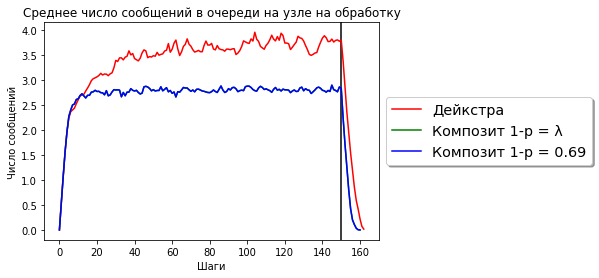

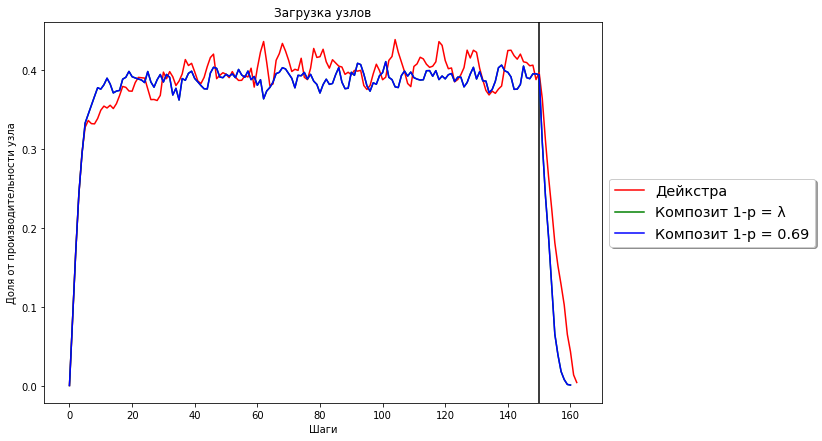

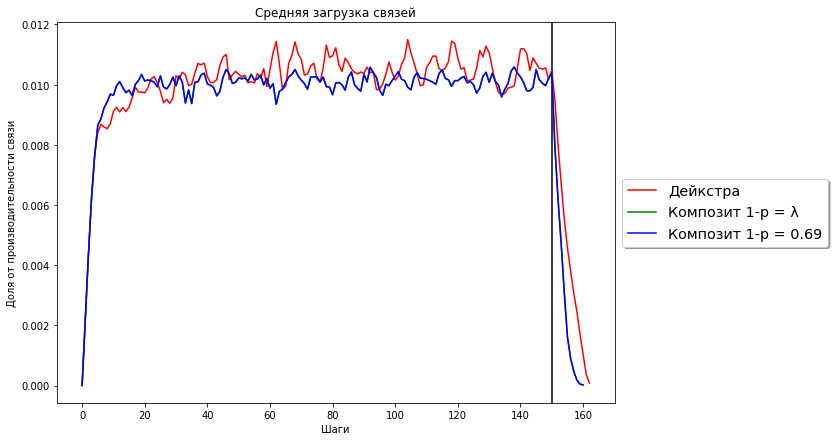

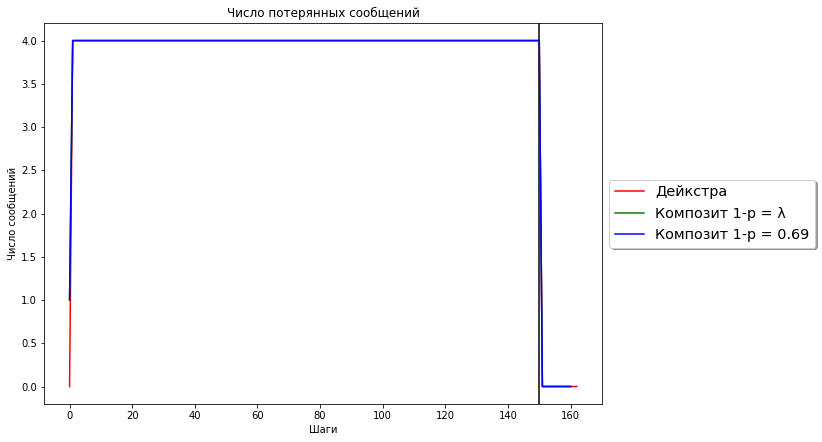

Доставлено 14401 Потеряно 3.9997% -Дейкстра
Доставлено 14400 Потеряно 4.0064% -Композит 1-p = λ
Доставлено 14400 Потеряно 4.0064% -Композит 1-p = 0.69


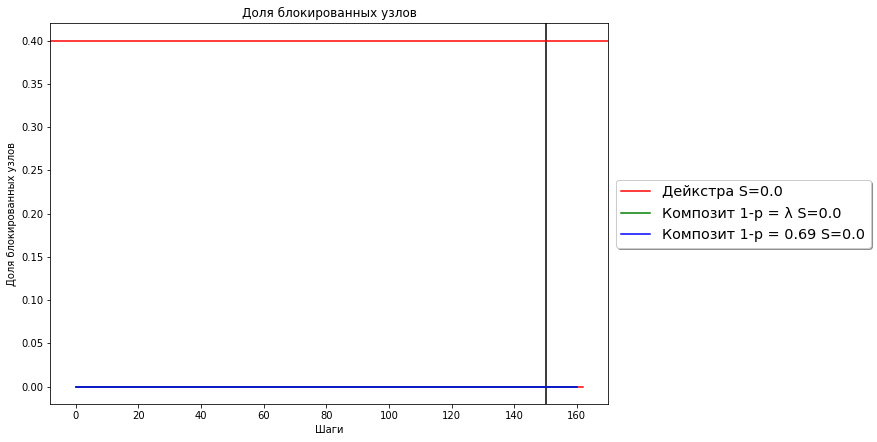

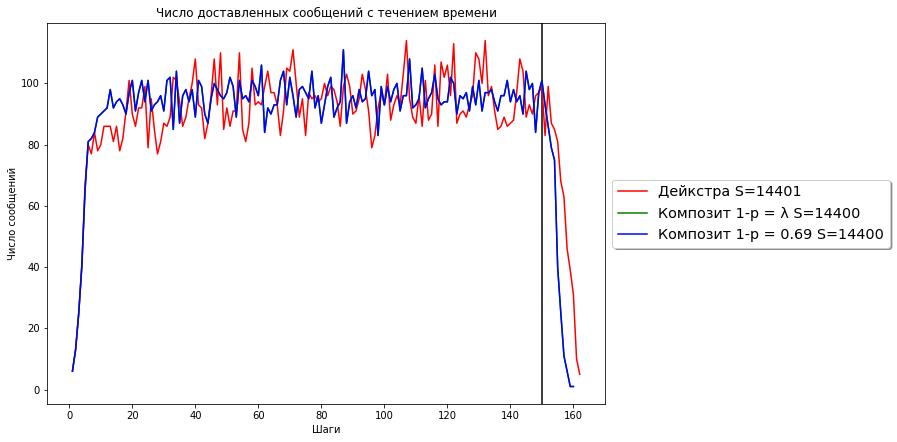

In [2]:
log_tags = [
 {"tag":  "3d709b56-9733-4548-864e-7b1f455cd11e", "label": "Дейкстра", "color": "red"},
 #{"tag":  "66872dd3-aad2-4a47-ad59-4de52ed29940", "label": "Композит 1-p = 0.95", "color": ""},
 {"tag":  "118c44af-cb86-4960-9f0a-34ce3d5c9159", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "c7ccb396-6333-4c87-8e6f-fd92c02e91cb", "label": "Композит 1-p = 0.69", "color": "blue"},
    #  magenta red green black
]
      
quantity = 100;                             
showStat()
showStatBlocked();  
showStatMessage(); 

<strong>Quantity 500 </strong>

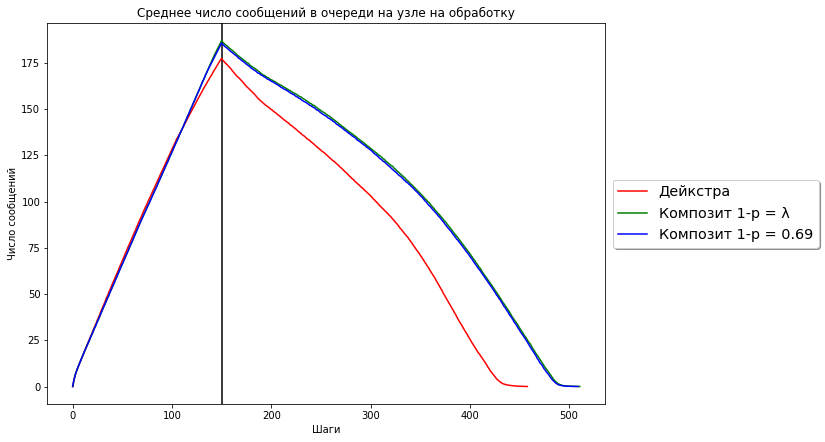

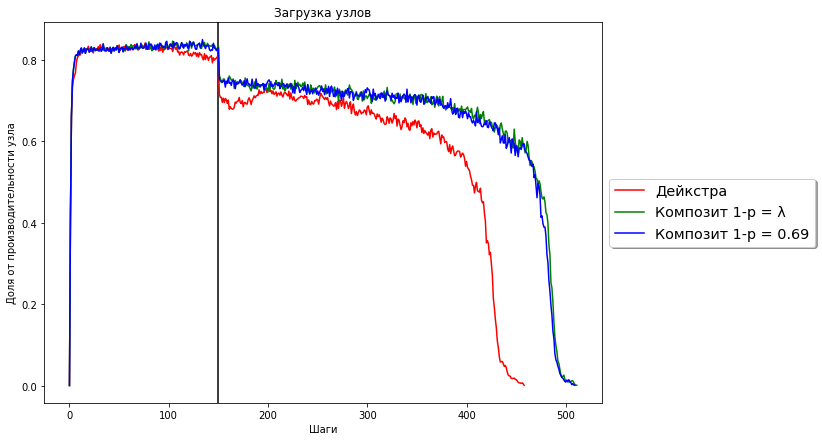

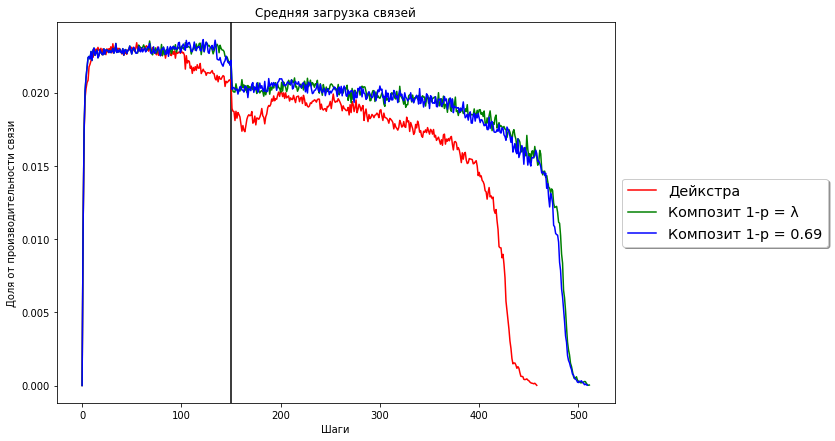

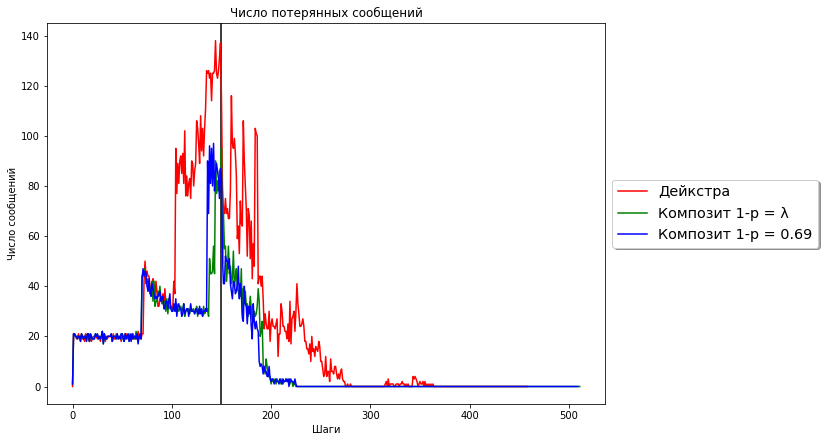

Доставлено 63153 Потеряно 15.7971% -Дейкстра
Доставлено 68803 Потеряно 8.2639% -Композит 1-p = λ
Доставлено 68681 Потеряно 8.4266% -Композит 1-p = 0.69


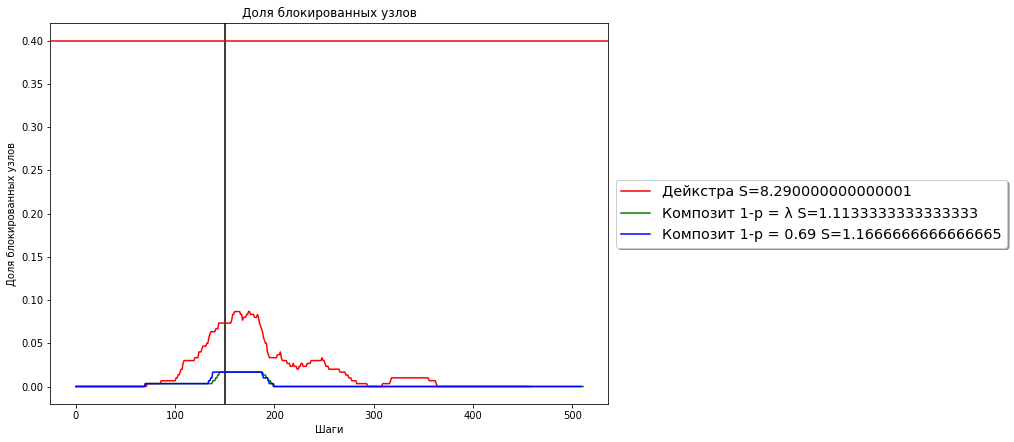

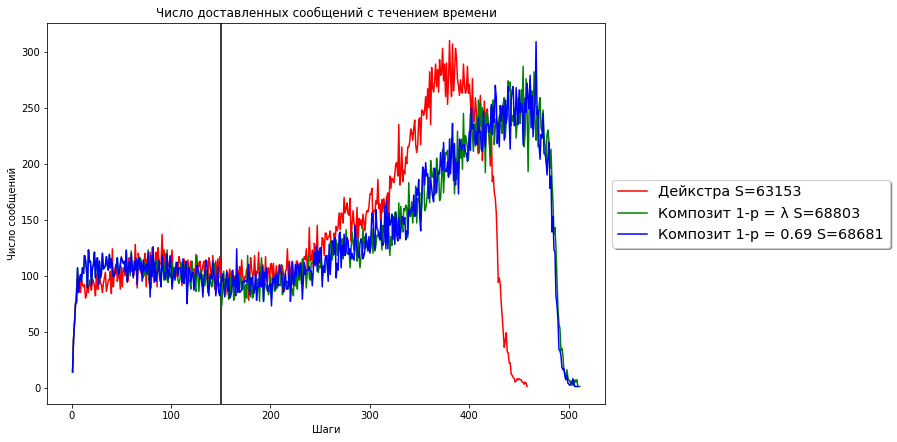

In [3]:
log_tags = [
 {"tag":  "87ada19d-c808-4658-9946-76f3a26645d1", "label": "Дейкстра", "color": "red"},
 #{"tag":  "d4757e03-f4de-4e75-b736-821b544dfe17", "label": "Композит 1-p = 0.95", "color": ""},
 {"tag":  "96c3c1e1-51f6-4fc9-bddd-9fe3484ea6b7", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "32b58ec5-cfb9-493e-a1d6-e837a8799bab", "label": "Композит 1-p = 0.69", "color": "blue"},
]
quantity = 500; 
showStat()
showStatBlocked();  
showStatMessage(); 

<strong>Quantity 1000 </strong>

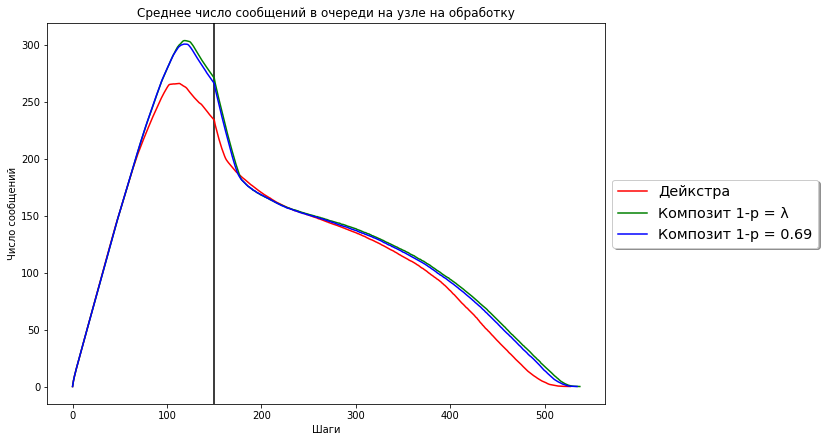

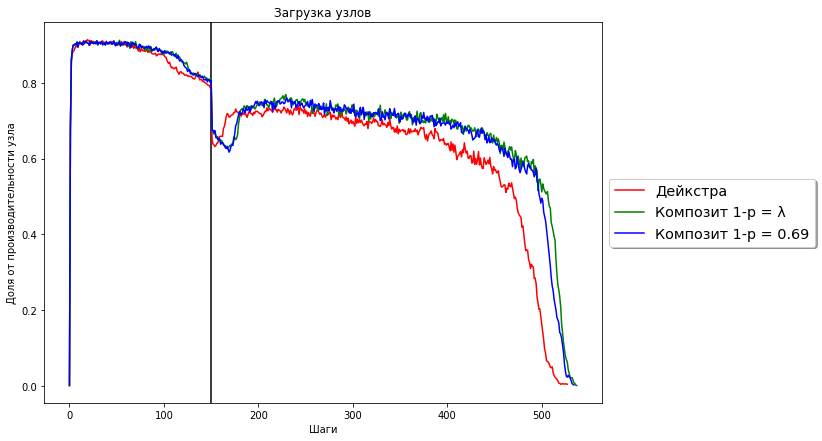

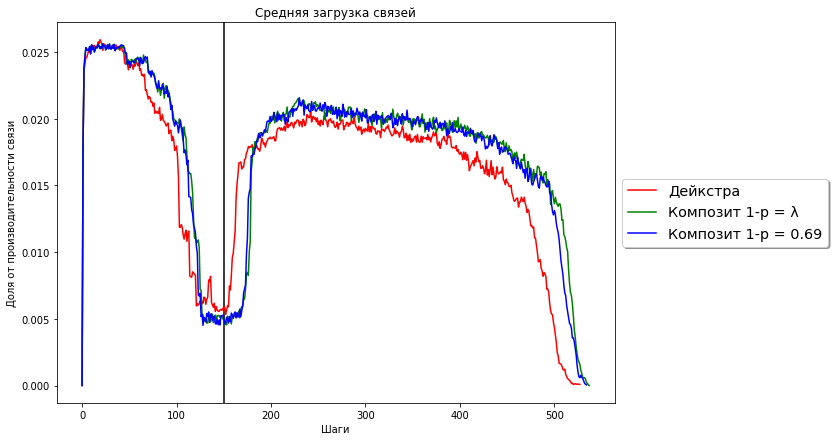

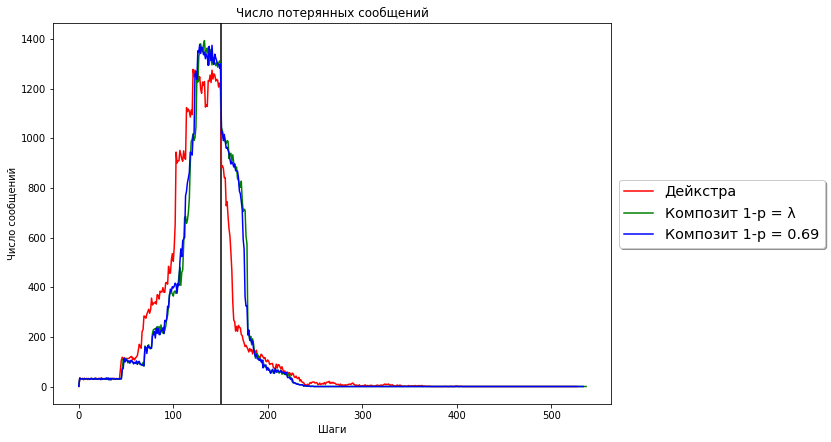

Доставлено 59437 Потеряно 60.3756% -Дейкстра
Доставлено 59801 Потеряно 60.1329% -Композит 1-p = λ
Доставлено 59925 Потеряно 60.0503% -Композит 1-p = 0.69


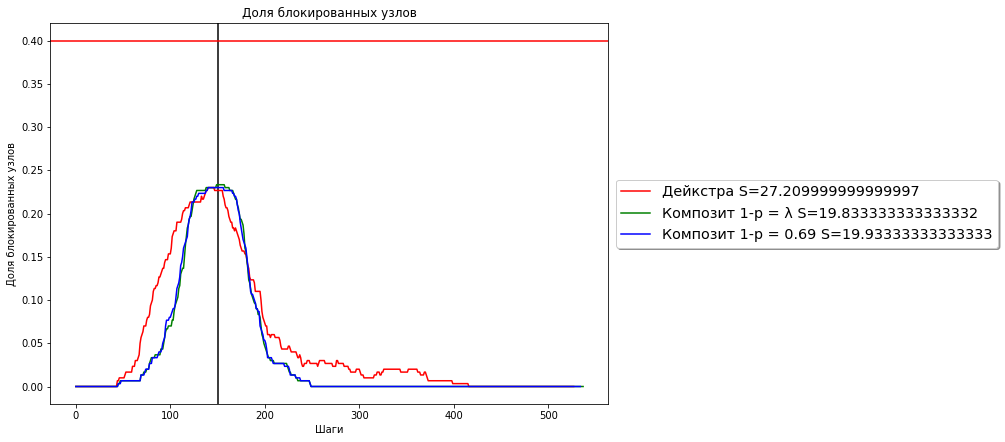

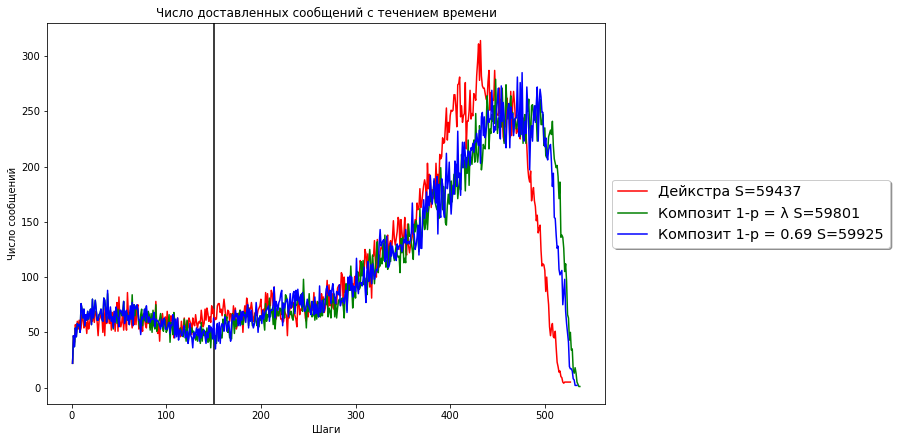

In [4]:
log_tags = [
 {"tag":  "cd896aa3-be97-4348-a371-6afaf29de994", "label": "Дейкстра", "color": "red"},
 #{"tag":  "8b06eba0-5d75-426c-98b4-25cdfe9a26fc", "label": "Композит 1-p = 0.95", "color": ""},
 {"tag":  "73a5be18-bf60-42d8-960b-5e946483c5c7", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "1e2ea278-1258-4431-b70d-4952d15b944c", "label": "Композит 1-p = 0.69", "color": "blue"},
]
quantity = 1000; 
showStat()
showStatBlocked();  
showStatMessage();

<strong>Quantity 1500 </strong>

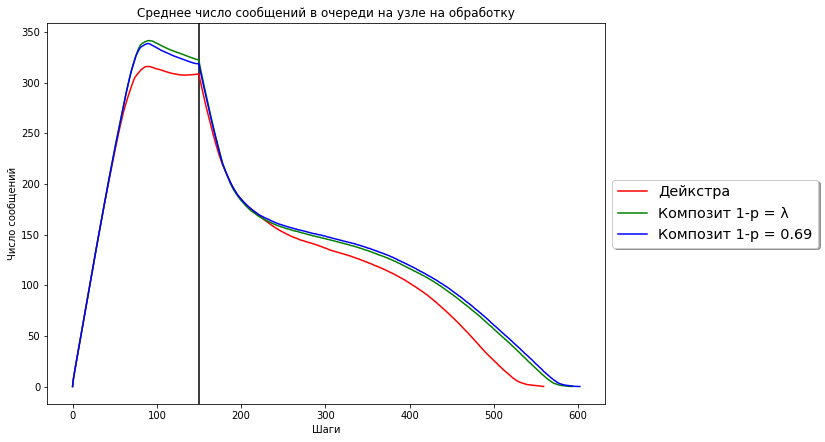

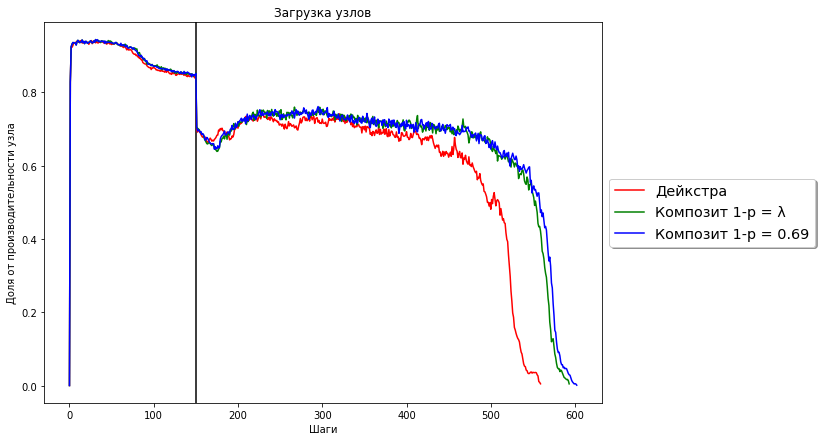

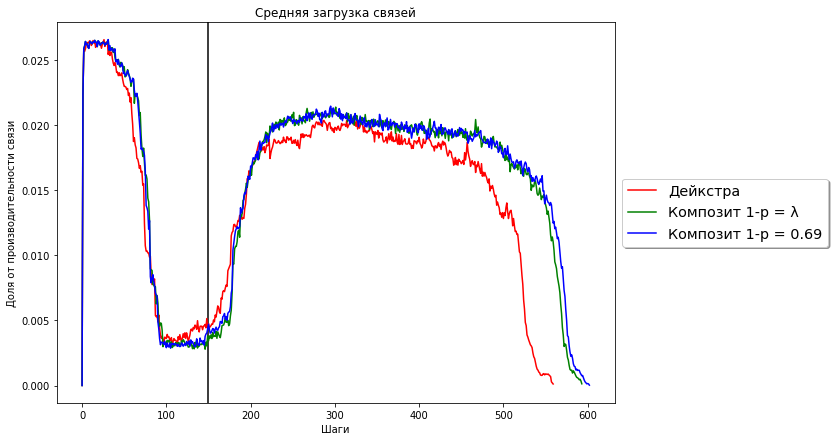

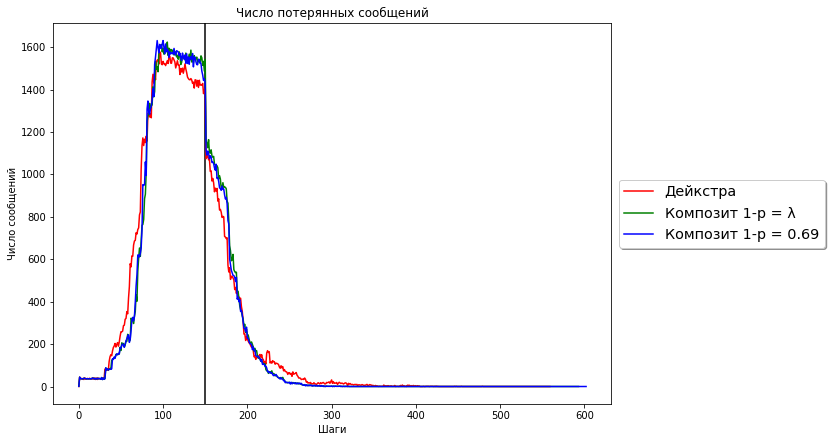

Доставлено 56040 Потеряно 75.0934% -Дейкстра
Доставлено 58342 Потеряно 74.0703% -Композит 1-p = λ
Доставлено 58991 Потеряно 73.7819% -Композит 1-p = 0.69


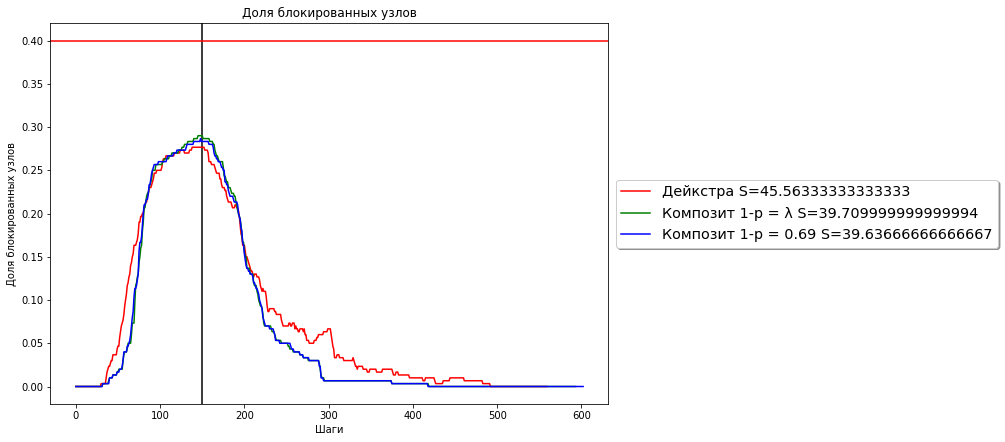

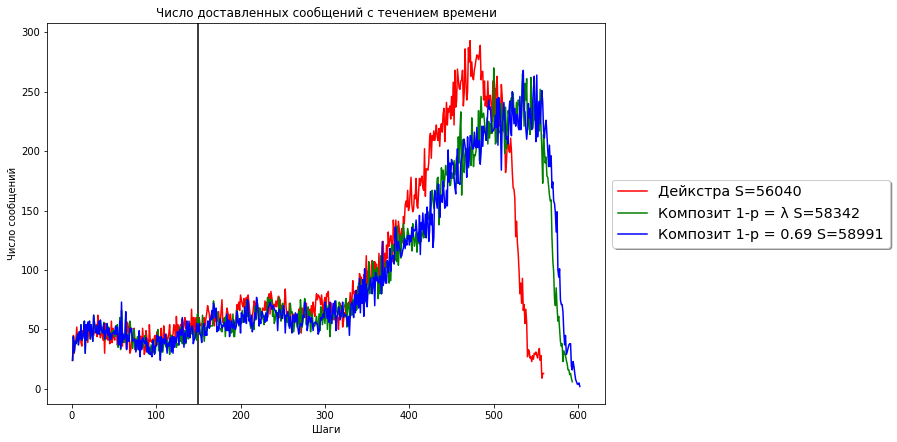

In [5]:
log_tags = [
 {"tag":  "ded57dcb-271b-4d22-b1ca-150869cbc109", "label": "Дейкстра", "color": "red"},
 #{"tag":  "e0ca3ab2-a902-4b06-96b9-db892dc1bc99", "label": "Композит 1-p = 0.95", "color": ""},
 {"tag":  "0e143fb3-2786-486e-9b8c-3d0a5c4ed36d", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "0d5dfe70-1e9f-4602-bb82-06afbb2d84aa", "label": "Композит 1-p = 0.69", "color": "blue"},
]
quantity = 1500; 
showStat()
showStatBlocked();  
showStatMessage();

Доставлено 42257 Потеряно 6.0976% -Дейкстра
Доставлено 43350 Потеряно 3.6688% -Композит 1-p = λ
Доставлено 43350 Потеряно 3.6688% -Композит 1-p = 0.69


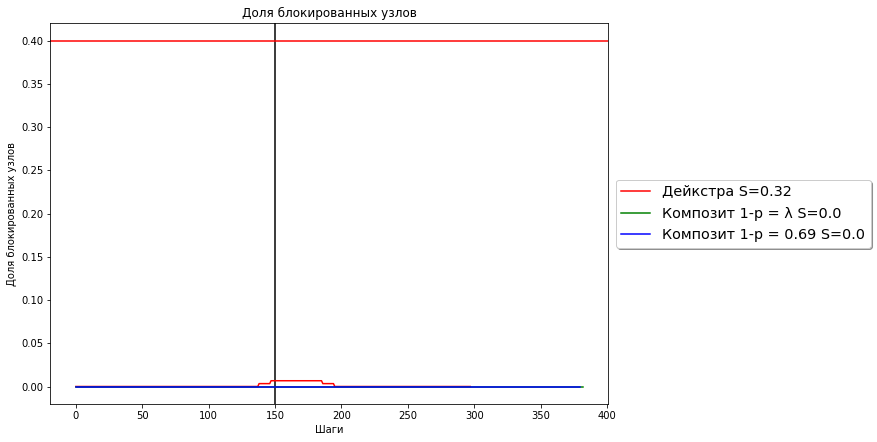

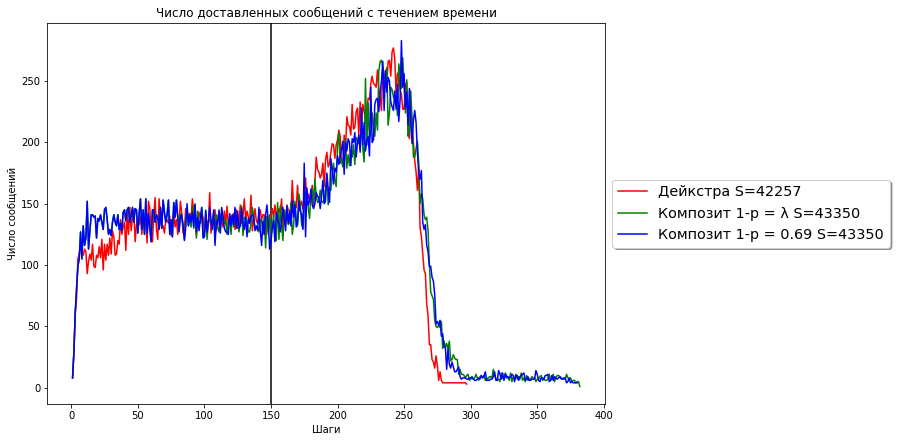

Доставлено 62047 Потеряно 40.9082% -Дейкстра
Доставлено 80827 Потеряно 23.0226% -Композит 1-p = λ
Доставлено 79649 Потеряно 24.1445% -Композит 1-p = 0.69


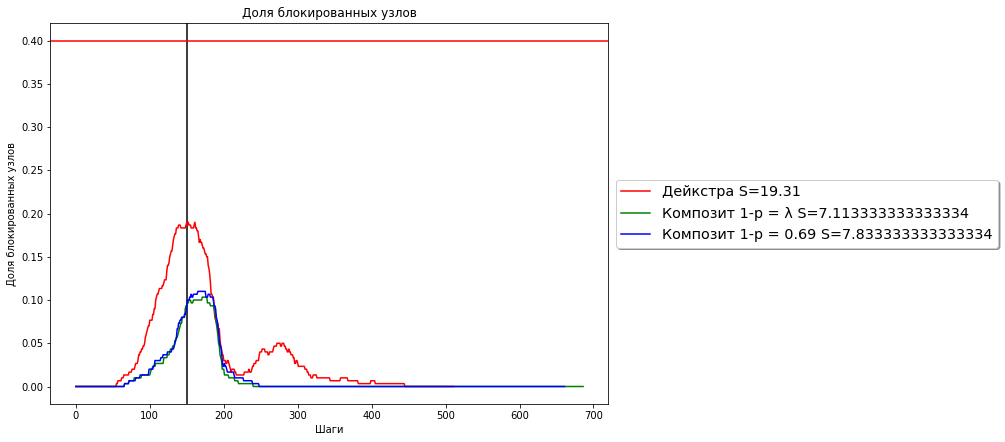

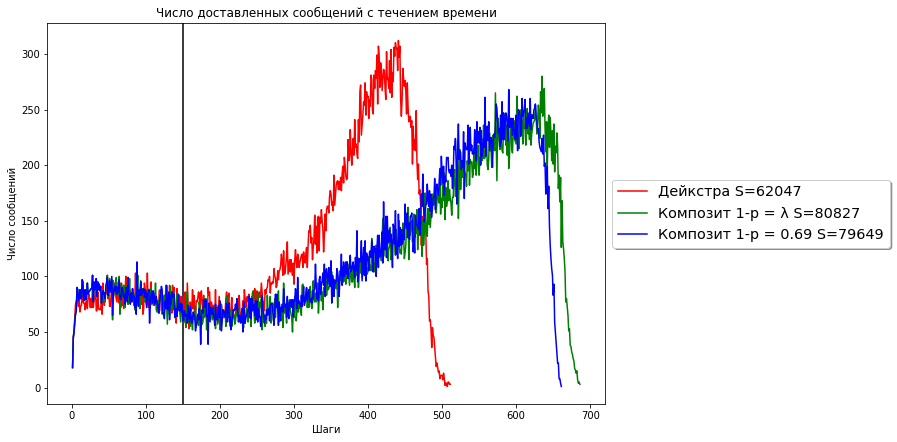

Доставлено 60908 Потеряно 54.8833% -Дейкстра
Доставлено 60853 Потеряно 54.9240% -Композит 1-p = λ
Доставлено 60805 Потеряно 54.9596% -Композит 1-p = 0.69


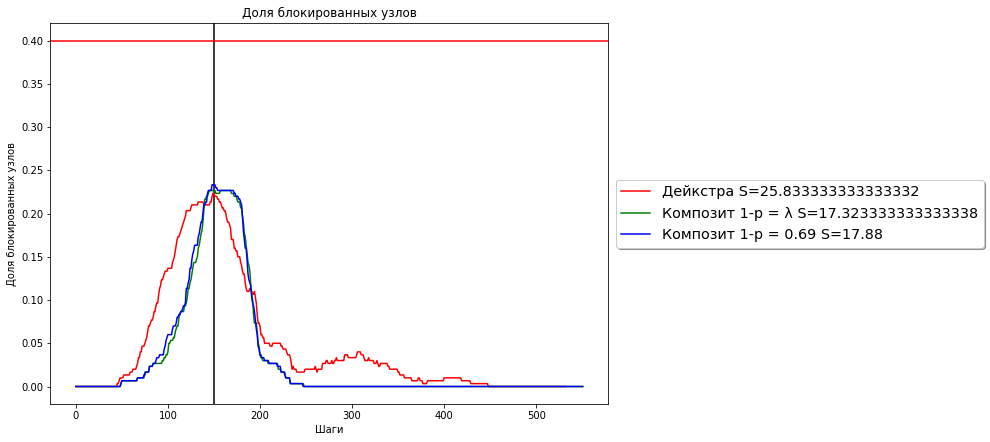

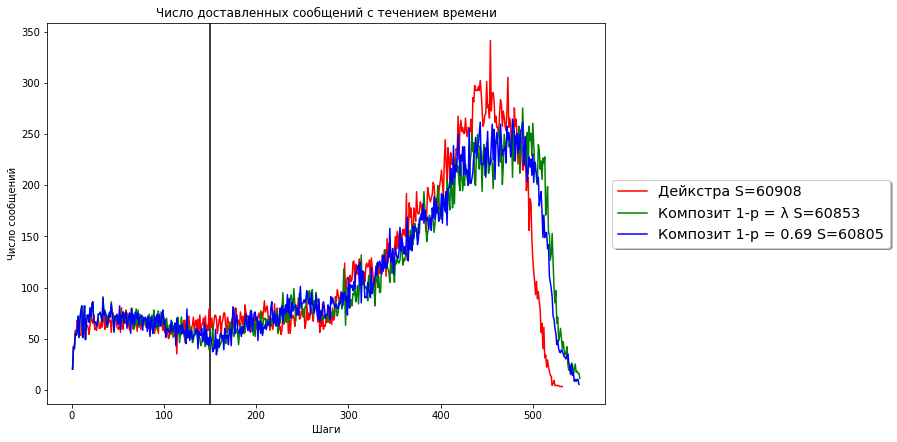

Доставлено 55159 Потеряно 71.7135% -Дейкстра
Доставлено 57564 Потеряно 70.4802% -Композит 1-p = λ
Доставлено 58209 Потеряно 70.1494% -Композит 1-p = 0.69


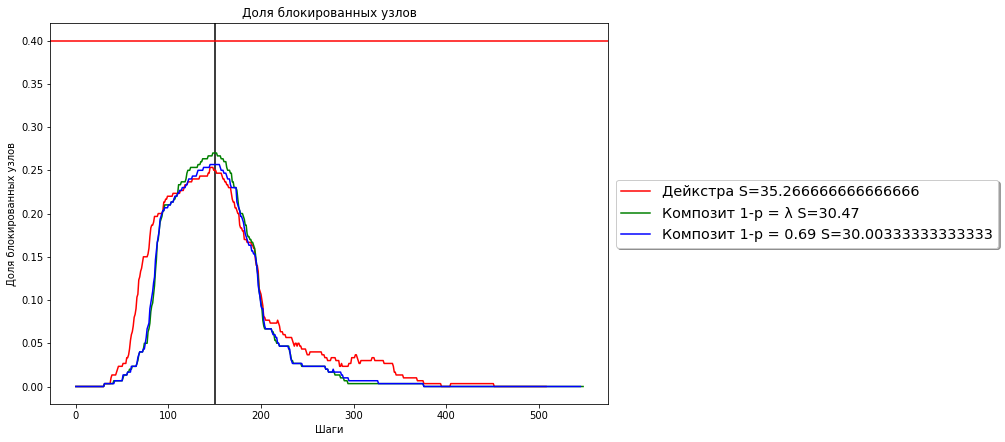

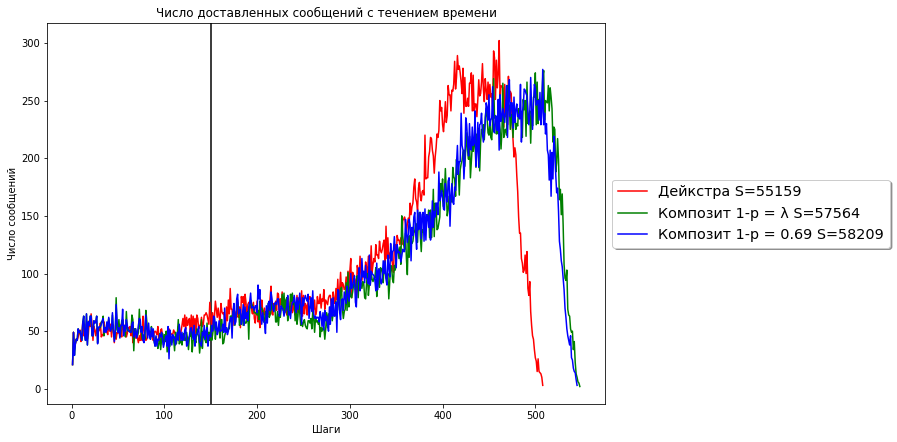

In [6]:
quantity = 300;  
log_tags = [
 {"tag":  "444d98dd-7d23-41c3-bcc1-4e3ecfac677a", "label": "Дейкстра", "color": "red"},
 {"tag":  "180152be-13f9-4c3d-9f8b-5f24feee7b47", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "b742de40-2df6-47a8-9cb2-19de489d8750", "label": "Композит 1-p = 0.69", "color": "blue"},
]
showStatBlocked();  
showStatMessage();

quantity = 700;  
log_tags = [
 {"tag":  "c97e8132-8ac1-4efb-860c-88935a336ac8", "label": "Дейкстра", "color": "red"},
 {"tag":  "0eba8308-bf20-4988-9462-0e45bbffe693", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "50805ba9-d468-426d-aaec-9b16ed9191ad", "label": "Композит 1-p = 0.69", "color": "blue"},
]
showStatBlocked();  
showStatMessage();

quantity = 900;  
log_tags = [
 {"tag":  "1dafbc5c-84dc-44b8-a919-92c672bc6323", "label": "Дейкстра", "color": "red"},
 {"tag":  "325bd1cd-5df1-404e-8d01-d0634e2789a3", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "08521811-789d-4702-8655-8be48b3f59f4", "label": "Композит 1-p = 0.69", "color": "blue"},
]
showStatBlocked();  
showStatMessage();

quantity = 1300;  
log_tags = [
 {"tag":  "b91e1ab4-9103-462d-8c8b-c9be58ffff49", "label": "Дейкстра", "color": "red"},
 {"tag":  "ee868107-6119-43cf-b7a7-bb38225d66f1", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "53222b51-fd32-4460-a343-bbaa5ade0117", "label": "Композит 1-p = 0.69", "color": "blue"},
]
showStatBlocked();  
showStatMessage();

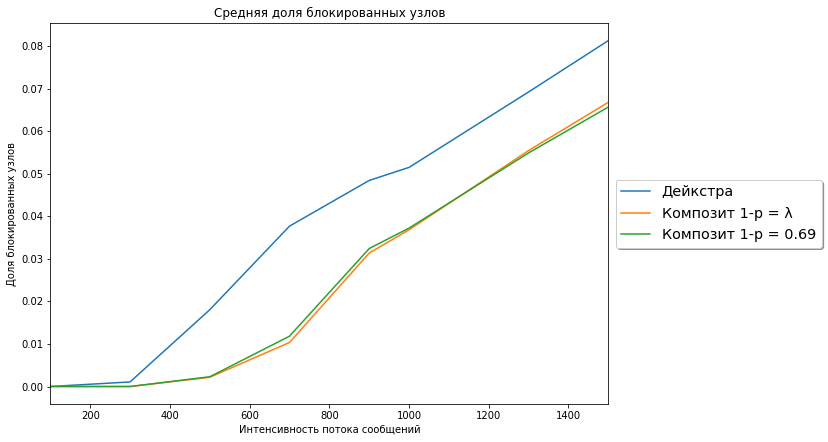

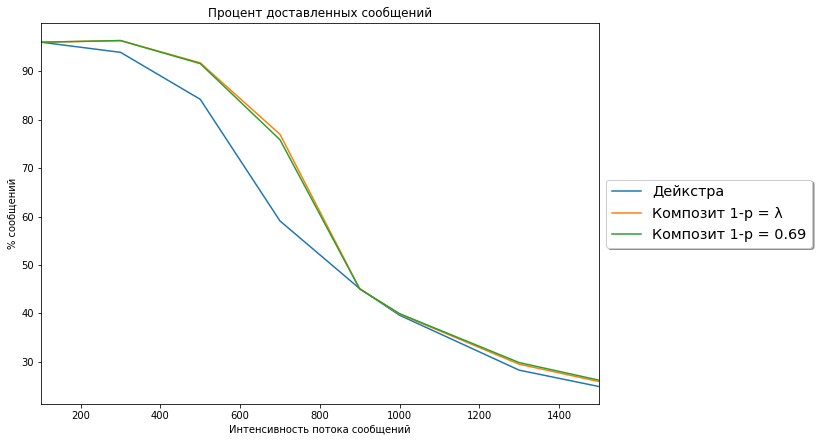

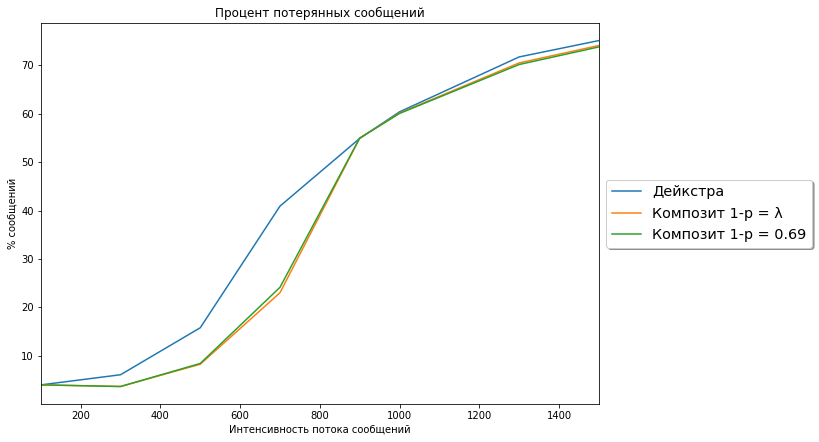

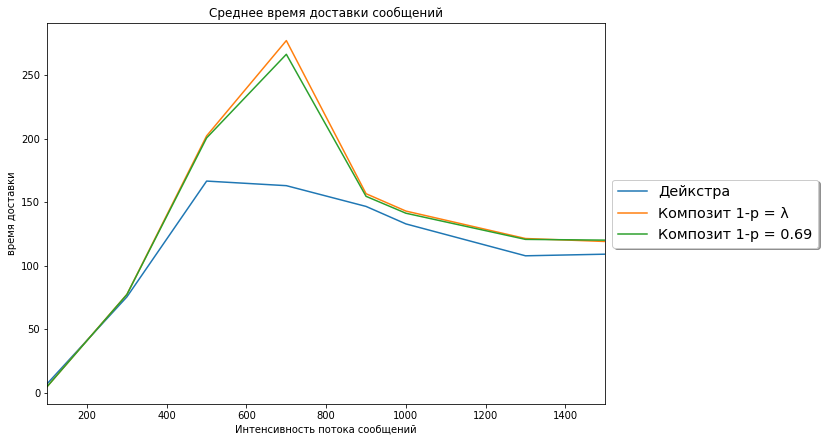

In [7]:
summBlocked.sort_index(inplace=True)
axs = summBlocked.plot()
axs.set_title("Средняя доля блокированных узлов")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("Доля блокированных узлов")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageResived.sort_index(inplace=True)
axs = MessageResived.plot()
axs.set_title("Процент доставленных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageFall.sort_index(inplace=True)
axs = MessageFall.plot()
axs.set_title("Процент потерянных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageTimeSpent.sort_index(inplace=True)
axs = MessageTimeSpent.plot()
axs.set_title("Среднее время доставки сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("время доставки")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()


In [8]:
print(summBlocked.mean().to_string())
print("")
print(MessageFall.mean().to_string())
print("")
print(MessageTimeSpent.mean().to_string())

Дейкстра               0.038438
Композит 1-p = λ       0.025391
Композит 1-p = 0.69    0.025564

Дейкстра               41.108562
Композит 1-p = λ       37.321149
Композит 1-p = 0.69    37.398429

Дейкстра               113.628140
Композит 1-p = λ       137.753356
Композит 1-p = 0.69    135.762569
